In [1]:
import pandas as pd
import numpy as np
import os
import glob
import random
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
col = ['Day','Hour', 'TARGET', 'DHI', 'DNI', 'NET']

def preprocess_data(data, is_train=True):
    
    temp = data.copy()
    
    temp['NET'] = 37-(37-temp['T'])/(0.68-0.0014*temp.RH+1/(1.76+1.4*temp.WS**0.75))-0.29*temp['T']*(1-0.001*temp.RH)
    
    temp = temp[col]

    if is_train==True:          
    
        temp['Target1'] = temp['TARGET'].shift(-48).fillna(method='ffill')
        temp['Target2'] = temp['TARGET'].shift(-48*2).fillna(method='ffill')
        temp = temp.dropna()
        
        return temp.iloc[:-96]

    elif is_train==False:
        
        temp = temp[col]
                              
        return temp.iloc[-48:, :]

In [37]:
df_test.columns

Index(['Day', 'Hour', 'TARGET', 'DHI', 'DNI', 'WS', 'RH', 'T'], dtype='object')

In [38]:
col = ['Day', 'Hour', 'TARGET', 'DHI', 'DNI', 'WS', 'RH', 'T']

def preprocess_data(data, is_train=True):
    
    temp = data.copy()
    temp = temp[['Day','Hour', 'TARGET', 'DHI', 'DNI', 'WS', 'RH', 'T']]

    if is_train==True:          
    
        temp['Target1'] = temp['TARGET'].shift(-48).fillna(method='ffill')
        temp['Target2'] = temp['TARGET'].shift(-48*2).fillna(method='ffill')
        temp = temp.dropna()
        
        return temp.iloc[:-96]

    elif is_train==False:
        
        temp = temp[['Day','Hour', 'TARGET', 'DHI', 'DNI', 'WS', 'RH', 'T']]
                              
        return temp.iloc[-48:, :]

In [33]:
train = pd.read_csv('./data/train/train.csv')

test = []

for i in range(81):
    file_path = './data/test/' + str(i) + '.csv'
    temp = pd.read_csv(file_path)
    temp['Day'] = i
    temp = preprocess_data(temp, is_train=False)
    test.append(temp)

df_test = pd.concat(test)

submission = pd.read_csv('./data/sample_submission.csv')

In [39]:
df_train = preprocess_data(train)

df_train.shape, df_test.shape

((52464, 10), (3888, 8))

In [40]:
df_train.WS = np.log1p(df_train.WS)
df_test.WS = np.log1p(df_test.WS)

In [41]:
min = df_train[col].min()
max  = df_train[col].max()

In [42]:
for i, col in enumerate(col):
    df_train[col] = (df_train[col] - min[i]) / (max[i] - min[i])
    df_test[col] = (df_test[col] - min[i]) / (max[i] - min[i])

In [43]:
Day0 = df_train.iloc[:, :-2]
Day  = df_train.iloc[:, 1:-2]
Day7 = df_train.iloc[:, -2]
Day8 = df_train.iloc[:, -1]
Day78 = df_train.iloc[:, -2:]

df_test0 = df_test.copy()
df_test = df_test.iloc[:, 1:]

In [8]:
def quantile_loss(q, y, pred):
    err = (y-pred)
    return mean(maximum(q*err, (q-1)*err), axis=-1)

In [9]:
q_lst = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [44]:
from sklearn.model_selection import train_test_split

X_train, X_valid, Y_train, Y_valid = train_test_split(Day, Day78, test_size=0.25, random_state=42)

X_train_1, X_valid_1, Y_train_1, Y_valid_1 = train_test_split(Day, Day7, test_size=0.25, random_state=42)
X_train_2, X_valid_2, Y_train_2, Y_valid_2 = train_test_split(Day, Day8, test_size=0.25, random_state=42)

X_train.shape, X_valid.shape, Y_train.shape, Y_valid.shape

((39348, 7), (13116, 7), (39348, 2), (13116, 2))

In [11]:
import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras import layers
from tensorflow.keras.backend import mean, maximum

tf.random.set_seed(42)

epoch = 100

In [45]:
model = tf.keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(Day.shape)),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(2)
])

model.compile(loss='mse', optimizer='adam')
hist = model.fit(X_train, Y_train, epochs=epoch, batch_size=48, validation_split=0.25, 
callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, mode='min', monitor='val_loss', verbose=1)])
model.evaluate(X_valid, Y_valid)

Epoch 1/100
615/615 [==============================] - 1s 1ms/step - loss: 473.2456 - val_loss: 167.4784
Epoch 2/100
615/615 [==============================] - 1s 1ms/step - loss: 164.7995 - val_loss: 152.2804
Epoch 3/100
615/615 [==============================] - 1s 1ms/step - loss: 148.9799 - val_loss: 143.0434
Epoch 4/100
615/615 [==============================] - 1s 1ms/step - loss: 146.6482 - val_loss: 141.6473
Epoch 5/100
615/615 [==============================] - 1s 1ms/step - loss: 139.9642 - val_loss: 137.6312
Epoch 6/100
615/615 [==============================] - 1s 1ms/step - loss: 140.5633 - val_loss: 138.0333
Epoch 7/100
615/615 [==============================] - 1s 1ms/step - loss: 138.6093 - val_loss: 135.1270
Epoch 8/100
615/615 [==============================] - 1s 1ms/step - loss: 132.6183 - val_loss: 135.1921
Epoch 9/100
615/615 [==============================] - 1s 1ms/step - loss: 136.0814 - val_loss: 133.8816
Epoch 10/100
615/615 [==============================] -

131.2332763671875

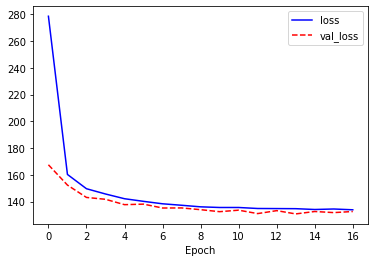

In [46]:
plt.plot(hist.history['loss'], 'b-', label='loss')
plt.plot(hist.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [47]:
results = pd.DataFrame()

for q in q_lst:
    model.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model.fit(Day, Day78, epochs=epoch, batch_size=48, validation_split=0.25, 
callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, mode='min', monitor='val_loss', verbose=1)])
    pred = pd.DataFrame(model.predict(df_test))
    results = pd.concat([results, pred], axis=1)

results.shape

Epoch 1/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4435 - val_loss: 1.5553
Epoch 2/100
820/820 [==============================] - 1s 1ms/step - loss: 1.3840 - val_loss: 1.5420
Epoch 3/100
820/820 [==============================] - 1s 1ms/step - loss: 1.3711 - val_loss: 1.5563
Epoch 4/100
820/820 [==============================] - 1s 1ms/step - loss: 1.3592 - val_loss: 1.5389
Epoch 5/100
820/820 [==============================] - 1s 1ms/step - loss: 1.3696 - val_loss: 1.5477
Epoch 6/100
820/820 [==============================] - 1s 1ms/step - loss: 1.3578 - val_loss: 1.5690
Epoch 7/100
820/820 [==============================] - 1s 1ms/step - loss: 1.3646 - val_loss: 1.5435
Epoch 00007: early stopping
Epoch 1/100
820/820 [==============================] - 2s 1ms/step - loss: 2.2280 - val_loss: 2.5484
Epoch 2/100
820/820 [==============================] - 1s 1ms/step - loss: 2.2057 - val_loss: 2.5236
Epoch 3/100
820/820 [==============================] - 1s 1ms/s

Epoch 1/100
820/820 [==============================] - 2s 1ms/step - loss: 2.6390 - val_loss: 2.9884
Epoch 2/100
820/820 [==============================] - 1s 1ms/step - loss: 2.6025 - val_loss: 2.9911
Epoch 3/100
820/820 [==============================] - 1s 1ms/step - loss: 2.6135 - val_loss: 2.9995
Epoch 4/100
820/820 [==============================] - 1s 1ms/step - loss: 2.6054 - val_loss: 3.0282
Epoch 00004: early stopping
Epoch 1/100
820/820 [==============================] - 2s 1ms/step - loss: 2.3318 - val_loss: 2.6847
Epoch 2/100
820/820 [==============================] - 1s 1ms/step - loss: 2.3126 - val_loss: 2.6687
Epoch 3/100
820/820 [==============================] - 1s 1ms/step - loss: 2.3198 - val_loss: 2.7079
Epoch 4/100
820/820 [==============================] - 1s 1ms/step - loss: 2.3138 - val_loss: 2.6835
Epoch 5/100
820/820 [==============================] - 1s 1ms/step - loss: 2.3249 - val_loss: 2.6941
Epoch 00005: early stopping
Epoch 1/100
820/820 [==============

820/820 [==============================] - 2s 1ms/step - loss: 0.7810 - val_loss: 0.8715
Epoch 2/100
820/820 [==============================] - 1s 1ms/step - loss: 0.7632 - val_loss: 0.8912
Epoch 3/100
820/820 [==============================] - 1s 1ms/step - loss: 0.7746 - val_loss: 0.8905
Epoch 4/100
820/820 [==============================] - 1s 1ms/step - loss: 0.7694 - val_loss: 0.9020
Epoch 00004: early stopping


(3888, 18)

In [48]:
results[1][:48]

,1,1,1,1,1,1,1,1,1
0,-0.106918,-0.120948,-0.079273,0.062259,-0.191842,0.025832,0.002594,-0.002217,0.114272
1,-0.104244,-0.121900,-0.079003,0.058536,-0.192401,0.022430,-0.000514,-0.002309,0.112941
2,-0.100999,-0.124836,-0.070515,-0.008604,-0.180071,-0.001472,-0.009600,0.001669,0.114387
3,-0.104531,-0.125177,-0.070703,-0.006476,-0.180108,-0.000270,-0.008582,0.001346,0.113966
4,-0.105793,-0.126267,-0.062580,-0.005565,-0.165916,-0.003966,-0.008398,0.003413,0.114762
5,-0.108143,-0.128241,-0.062087,-0.004919,-0.165554,-0.005609,-0.009637,0.003766,0.116329
6,-0.115231,-0.131903,-0.053621,-0.001259,-0.150381,-0.006834,-0.009636,0.007550,0.117830
7,-0.117750,-0.133064,-0.051847,0.000477,-0.148185,-0.003416,-0.011120,0.006938,0.127272
8,-0.117665,-0.135536,-0.043223,0.005278,-0.129848,-0.000313,-0.005668,0.008908,0.133470
9,-0.118352,-0.136167,-0.045217,0.004708,-0.130463,-0.000676,-0.004389,0.008692,0.137462


In [16]:
from lightgbm import LGBMRegressor

In [49]:
def LGBM(q, X_train, Y_train, X_valid, Y_valid, X_test):
    
    # (a) Modeling  
    model = LGBMRegressor(objective='quantile', alpha=q,
                         n_estimators=10000, bagging_fraction=0.7, learning_rate=0.027, subsample=0.7)                   
                         
                         
    model.fit(X_train, Y_train, eval_metric = ['quantile'], 
          eval_set=[(X_valid, Y_valid)], early_stopping_rounds=300, verbose=500)

    # (b) Predictions
    pred = pd.Series(model.predict(X_test).round(2))
    return pred, model

def train_data(X_train, Y_train, X_valid, Y_valid, X_test):

    LGBM_models=[]
    LGBM_actual_pred = pd.DataFrame()

    for q in q_lst:
        print(q)
        pred , model = LGBM(q, X_train, Y_train, X_valid, Y_valid, X_test)
        LGBM_models.append(model)
        LGBM_actual_pred = pd.concat([LGBM_actual_pred,pred],axis=1)

    LGBM_actual_pred.columns=q_lst
    
    return LGBM_models, LGBM_actual_pred

models_1, results_1 = train_data(X_train_1, Y_train_1, X_valid_1, Y_valid_1, df_test)
models_2, results_2 = train_data(X_train_2, Y_train_2, X_valid_2, Y_valid_2, df_test)

0.1
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 1.34889
Early stopping, best iteration is:
[418]	valid_0's quantile: 1.34812
0.2
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.14466
[1000]	valid_0's quantile: 2.13764
[1500]	valid_0's quantile: 2.13582
[2000]	valid_0's quantile: 2.1334
Early stopping, best iteration is:
[1749]	valid_0's quantile: 2.13312
0.3
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.53565
[1000]	valid_0's quantile: 2.50726
[1500]	valid_0's quantile: 2.49216
Early stopping, best iteration is:
[1604]	valid_0's quantile: 2.48959
0.4
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.66191
[1000]	valid_0's quantile: 2.62846
[1500]	valid_0's quantile: 2.61266
[2000]	valid_0's quantile: 2.6059
[2500]	valid_0's quantile: 2.59923
[3000]	valid_0's quantile: 2.59644
Early stopping, best iteration is:
[2707]	v

In [50]:
results_1[:48]

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [51]:
results_2[:48]

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [20]:
model7 = tf.keras.Sequential([
    layers.Conv1D(filters=128, kernel_size=2, padding='same', activation='relu'),
    layers.Conv1D(filters=64, kernel_size=2, padding='same', activation='relu'),
    layers.Conv1D(filters=32, kernel_size=2, padding='same', activation='relu'),
    layers.Dense(1)
])

result7 = pd.DataFrame()

for q in q_lst:
    print(q)
    model7.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model7.fit(np.array(Day).reshape(52464, 1, 5), np.array(Day7).reshape(52464, 1), epochs=epoch, batch_size=48, validation_split=0.25, 
                callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, mode='min', monitor='val_loss', verbose=1)])
    pred7 = np.squeeze(model7.predict(np.array(df_test).reshape(3888, 1, 5)))
    pred7 = pd.DataFrame(pred7)
    result7 = pd.concat([result7, pred7], axis=1)
    
result7[:48]

0.1
Epoch 1/100
820/820 [==============================] - 3s 3ms/step - loss: 1.5208 - val_loss: 1.5986
Epoch 2/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4160 - val_loss: 1.5863
Epoch 3/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4031 - val_loss: 1.5770
Epoch 4/100
820/820 [==============================] - 2s 2ms/step - loss: 1.3982 - val_loss: 1.5685
Epoch 5/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4022 - val_loss: 1.5659
Epoch 6/100
820/820 [==============================] - 2s 2ms/step - loss: 1.3864 - val_loss: 1.5852
Epoch 7/100
820/820 [==============================] - 2s 2ms/step - loss: 1.3860 - val_loss: 1.5699
Epoch 8/100
820/820 [==============================] - 2s 2ms/step - loss: 1.3978 - val_loss: 1.5535
Epoch 9/100
820/820 [==============================] - 2s 2ms/step - loss: 1.3806 - val_loss: 1.5508
Epoch 10/100
820/820 [==============================] - 2s 2ms/step - loss: 1.3874 - va

820/820 [==============================] - 2s 2ms/step - loss: 0.7636 - val_loss: 0.8622
Epoch 4/100
820/820 [==============================] - 2s 2ms/step - loss: 0.7608 - val_loss: 0.8849
Epoch 5/100
820/820 [==============================] - 2s 2ms/step - loss: 0.7598 - val_loss: 0.8709
Epoch 6/100
820/820 [==============================] - 2s 2ms/step - loss: 0.7613 - val_loss: 0.8635
Epoch 7/100
820/820 [==============================] - 2s 2ms/step - loss: 0.7714 - val_loss: 0.8558
Epoch 8/100
820/820 [==============================] - 2s 2ms/step - loss: 0.7687 - val_loss: 0.8525
Epoch 9/100
820/820 [==============================] - 2s 2ms/step - loss: 0.7481 - val_loss: 0.8758
Epoch 10/100
820/820 [==============================] - 2s 2ms/step - loss: 0.7672 - val_loss: 0.8520
Epoch 11/100
820/820 [==============================] - 2s 2ms/step - loss: 0.7338 - val_loss: 0.8657
Epoch 12/100
820/820 [==============================] - 2s 2ms/step - loss: 0.7511 - val_loss: 0.8731

,0,0,0,0,0,0,0,0,0
0,-0.002349,-0.000611,-5.322974e-05,-0.001132,0.001287,-0.000453,0.000094,-0.000818,0.005992
1,-0.002349,-0.000580,-4.089065e-05,-0.001100,0.001281,-0.000442,0.000066,-0.000804,0.005994
2,-0.002198,-0.000492,4.525296e-06,-0.001046,0.001263,-0.000440,0.000095,-0.000725,0.005838
3,-0.002197,-0.000501,-4.300103e-05,-0.001075,0.001268,-0.000448,0.000118,-0.000736,0.005836
4,-0.002052,-0.000492,-5.187932e-05,-0.001054,0.001242,-0.000459,0.000053,-0.000646,0.005708
5,-0.002055,-0.000510,-1.704227e-05,-0.001013,0.001232,-0.000440,0.000047,-0.000680,0.005774
6,-0.001904,-0.000562,-1.559872e-05,-0.000992,0.001202,-0.000428,-0.000017,-0.000629,0.005673
7,-0.001921,-0.000624,1.359722e-04,-0.000885,0.001193,-0.000394,-0.000101,-0.000778,0.005802
8,-0.001781,-0.000720,3.316626e-05,-0.000867,0.001141,-0.000372,-0.000097,-0.000742,0.005954
9,-0.001783,-0.000745,4.380196e-05,-0.000829,0.001127,-0.000356,-0.000067,-0.000820,0.006219


In [21]:
model8 = tf.keras.Sequential([
    layers.Conv1D(filters=128, kernel_size=2, padding='same', activation='relu'),
    layers.Conv1D(filters=64, kernel_size=2, padding='same', activation='relu'),
    layers.Conv1D(filters=32, kernel_size=2, padding='same', activation='relu'),
    layers.Dense(1)
])

result8 = pd.DataFrame()

for q in q_lst:
    print(q)
    model8.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model8.fit(np.array(Day).reshape(52464, 1, 5), np.array(Day8).reshape(52464, 1), epochs=epoch, batch_size=48, validation_split=0.25, 
                callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, mode='min', monitor='val_loss', verbose=1)])
    pred8 = np.squeeze(model8.predict(np.array(df_test).reshape(3888, 1, 5)))
    pred8 = pd.DataFrame(pred8)
    result8 = pd.concat([result8, pred8], axis=1)
    
result8[:48]

0.1
Epoch 1/100
820/820 [==============================] - 2s 2ms/step - loss: 1.5378 - val_loss: 1.6347
Epoch 2/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4440 - val_loss: 1.6298
Epoch 3/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4246 - val_loss: 1.6211
Epoch 4/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4092 - val_loss: 1.6122
Epoch 5/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4206 - val_loss: 1.6020
Epoch 6/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4106 - val_loss: 1.5911
Epoch 7/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4145 - val_loss: 1.5921
Epoch 8/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4157 - val_loss: 1.5877
Epoch 9/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4164 - val_loss: 1.5759
Epoch 10/100
820/820 [==============================] - 2s 2ms/step - loss: 1.4156 - va

820/820 [==============================] - 2s 2ms/step - loss: 2.4080 - val_loss: 2.7531
Epoch 8/100
820/820 [==============================] - 2s 2ms/step - loss: 2.4090 - val_loss: 2.7524
Epoch 9/100
820/820 [==============================] - 2s 2ms/step - loss: 2.3701 - val_loss: 2.7409
Epoch 10/100
820/820 [==============================] - 2s 2ms/step - loss: 2.4072 - val_loss: 2.7400
Epoch 11/100
820/820 [==============================] - 2s 2ms/step - loss: 2.3565 - val_loss: 2.7355
Epoch 12/100
820/820 [==============================] - 1s 2ms/step - loss: 2.3773 - val_loss: 2.7603
Epoch 13/100
820/820 [==============================] - 1s 2ms/step - loss: 2.3850 - val_loss: 2.7672
Epoch 14/100
820/820 [==============================] - 2s 2ms/step - loss: 2.3814 - val_loss: 2.7338
Epoch 15/100
820/820 [==============================] - 2s 2ms/step - loss: 2.3855 - val_loss: 2.7301
Epoch 16/100
820/820 [==============================] - 2s 2ms/step - loss: 2.3650 - val_loss: 2.

,0,0,0,0,0,0,0,0,0
0,-0.000396,-0.001752,0.000256,-0.001709,-0.000065,0.001711,0.001545,0.000740,0.003973
1,-0.000398,-0.001773,0.000254,-0.001708,-0.000039,0.001809,0.001610,0.000740,0.003927
2,-0.000269,-0.001641,0.000164,-0.001559,-0.000366,0.001501,0.001440,0.000736,0.004189
3,-0.000268,-0.001626,0.000163,-0.001559,-0.000385,0.001375,0.001374,0.000709,0.004200
4,-0.000142,-0.001491,0.000112,-0.001409,-0.000623,0.001391,0.000862,0.000731,0.004110
5,-0.000145,-0.001523,0.000115,-0.001409,-0.000570,0.001585,0.001127,0.000807,0.004115
6,-0.000021,-0.001444,0.000066,-0.001333,-0.000742,0.001488,0.000983,0.000824,0.003943
7,-0.000028,-0.001517,0.000069,-0.001455,-0.000634,0.001444,0.001430,0.000915,0.003835
8,0.000074,-0.001515,0.000018,-0.001498,-0.000749,0.001085,0.001843,0.000844,0.003537
9,0.000083,-0.001446,0.000069,-0.001516,-0.000791,0.000823,0.001793,0.000754,0.003116


In [53]:
model = tf.keras.Sequential([
    layers.GRU(units=64, return_sequences=True, input_shape=[39348, 7]),
    layers.GRU(units=32),
    layers.Dense(1)
])

model.compile(loss='mse', optimizer='adam')
model.fit(np.array(X_train_1).reshape(39348, 1, 7), np.array(Y_train_1).reshape(39348, 1), epochs=epoch, batch_size=48, validation_split=0.25, 
            callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, mode='min', monitor='val_loss', verbose=1)])
pred = np.squeeze(model8.predict(np.array(X_valid_1).reshape(13116, 1, 7)))

Epoch 1/100
615/615 [==============================] - 4s 4ms/step - loss: 702.2539 - val_loss: 363.4023
Epoch 2/100
615/615 [==============================] - 2s 3ms/step - loss: 303.1173 - val_loss: 228.7125
Epoch 3/100
615/615 [==============================] - 2s 3ms/step - loss: 207.5436 - val_loss: 184.3359
Epoch 4/100
615/615 [==============================] - 2s 3ms/step - loss: 179.8817 - val_loss: 165.4278
Epoch 5/100
615/615 [==============================] - 2s 3ms/step - loss: 161.5876 - val_loss: 157.0628
Epoch 6/100
615/615 [==============================] - 2s 3ms/step - loss: 155.0740 - val_loss: 152.5167
Epoch 7/100
615/615 [==============================] - 2s 3ms/step - loss: 153.6500 - val_loss: 151.7548
Epoch 8/100
615/615 [==============================] - 2s 3ms/step - loss: 146.0424 - val_loss: 148.0220
Epoch 9/100
615/615 [==============================] - 2s 4ms/step - loss: 149.6004 - val_loss: 146.1684
Epoch 10/100
615/615 [==============================] -

ValueError: in user code:

    C:\Users\okso6\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1478 predict_function  *
        return step_function(self, iterator)
    C:\Users\okso6\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\okso6\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\okso6\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\okso6\anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\okso6\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1461 run_step  **
        outputs = model.predict_step(data)
    C:\Users\okso6\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1434 predict_step
        return self(x, training=False)
    C:\Users\okso6\anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\okso6\anaconda3\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:259 assert_input_compatibility
        ' but received input with shape ' + display_shape(x.shape))

    ValueError: Input 0 of layer sequential_2 is incompatible with the layer: expected axis -1 of input shape to have value 5 but received input with shape (None, 1, 7)


In [54]:
model_G7 = tf.keras.Sequential([
    layers.GRU(units=64, return_sequences=True, input_shape=[52464, 7]),
    layers.GRU(units=32),
    layers.Dense(1)
])

result_G7 = pd.DataFrame()

for q in q_lst:
    print(q)
    model_G7.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model_G7.fit(np.array(Day).reshape(52464, 1, 7), np.array(Day7).reshape(52464, 1)
                 , epochs=epoch, batch_size=48, validation_split=0.25, 
                callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, mode='min', monitor='val_loss', verbose=1)])
    pred_G7 = np.squeeze(model_G7.predict(np.array(df_test).reshape(3888, 1, 7)))
    pred_G7 = pd.DataFrame(pred_G7)
    result_G7 = pd.concat([result_G7, pred_G7], axis=1)
    
result_G7[:48]

0.1
Epoch 1/100
820/820 [==============================] - 5s 3ms/step - loss: 1.5716 - val_loss: 1.6340
Epoch 2/100
820/820 [==============================] - 2s 3ms/step - loss: 1.4335 - val_loss: 1.6106
Epoch 3/100
820/820 [==============================] - 2s 3ms/step - loss: 1.4189 - val_loss: 1.6028
Epoch 4/100
820/820 [==============================] - 2s 3ms/step - loss: 1.4084 - val_loss: 1.5895
Epoch 5/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4090 - val_loss: 1.5825
Epoch 6/100
820/820 [==============================] - 3s 3ms/step - loss: 1.3946 - val_loss: 1.5906
Epoch 7/100
820/820 [==============================] - 3s 3ms/step - loss: 1.3963 - val_loss: 1.5829
Epoch 8/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4096 - val_loss: 1.5721
Epoch 9/100
820/820 [==============================] - 3s 3ms/step - loss: 1.3922 - val_loss: 1.5765
Epoch 10/100
820/820 [==============================] - 3s 3ms/step - loss: 1.4108 - va

820/820 [==============================] - 6s 4ms/step - loss: 2.6290 - val_loss: 2.9850
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 2.6030 - val_loss: 2.9764
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 2.6041 - val_loss: 2.9705
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - loss: 2.5737 - val_loss: 2.9727
Epoch 5/100
820/820 [==============================] - 3s 3ms/step - loss: 2.6136 - val_loss: 2.9682
Epoch 6/100
820/820 [==============================] - 3s 3ms/step - loss: 2.6072 - val_loss: 2.9951
Epoch 7/100
820/820 [==============================] - 3s 3ms/step - loss: 2.6201 - val_loss: 2.9628
Epoch 8/100
820/820 [==============================] - 3s 3ms/step - loss: 2.6437 - val_loss: 2.9642
Epoch 9/100
820/820 [==============================] - 3s 3ms/step - loss: 2.5943 - val_loss: 2.9549
Epoch 10/100
820/820 [==============================] - 3s 3ms/step - loss: 2.6463 - val_loss: 2.9621
E

820/820 [==============================] - 3s 4ms/step - loss: 2.5949 - val_loss: 2.9388
Epoch 14/100
820/820 [==============================] - 3s 4ms/step - loss: 2.5888 - val_loss: 2.9368
Epoch 00014: early stopping
0.6
Epoch 1/100
820/820 [==============================] - 6s 4ms/step - loss: 2.3702 - val_loss: 2.6541
Epoch 2/100
820/820 [==============================] - 3s 4ms/step - loss: 2.3352 - val_loss: 2.6476
Epoch 3/100
820/820 [==============================] - 3s 4ms/step - loss: 2.3317 - val_loss: 2.6360
Epoch 4/100
820/820 [==============================] - 3s 4ms/step - loss: 2.3217 - val_loss: 2.6633
Epoch 5/100
820/820 [==============================] - 3s 4ms/step - loss: 2.3355 - val_loss: 2.6596
Epoch 6/100
820/820 [==============================] - 3s 4ms/step - loss: 2.3451 - val_loss: 2.6344
Epoch 7/100
820/820 [==============================] - 3s 4ms/step - loss: 2.3392 - val_loss: 2.6141
Epoch 8/100
820/820 [==============================] - 3s 4ms/step - l

820/820 [==============================] - 6s 4ms/step - loss: 1.3754 - val_loss: 1.5805
Epoch 2/100
820/820 [==============================] - 3s 3ms/step - loss: 1.3488 - val_loss: 1.5820
Epoch 3/100
820/820 [==============================] - 3s 3ms/step - loss: 1.3710 - val_loss: 1.5807
Epoch 4/100
820/820 [==============================] - 3s 3ms/step - loss: 1.3588 - val_loss: 1.5834
Epoch 5/100
820/820 [==============================] - 3s 3ms/step - loss: 1.3609 - val_loss: 1.5714
Epoch 6/100
820/820 [==============================] - 3s 3ms/step - loss: 1.3638 - val_loss: 1.5621
Epoch 7/100
820/820 [==============================] - 3s 3ms/step - loss: 1.3704 - val_loss: 1.5668
Epoch 8/100
820/820 [==============================] - 3s 3ms/step - loss: 1.3826 - val_loss: 1.5616
Epoch 9/100
820/820 [==============================] - 3s 3ms/step - loss: 1.3480 - val_loss: 1.5510
Epoch 10/100
820/820 [==============================] - 3s 3ms/step - loss: 1.3738 - val_loss: 1.5505
E

,0,0,0,0,0,0,0,0,0
0,-0.075949,-0.011083,-0.016541,0.042628,0.027870,0.071423,0.067487,-0.037570,-0.059470
1,-0.076503,-0.010007,-0.014449,0.043075,0.028451,0.069447,0.066699,-0.036306,-0.059932
2,-0.070272,-0.006208,-0.014810,0.038965,0.060111,0.053406,0.043162,-0.032847,-0.065703
3,-0.069469,-0.006344,-0.016052,0.037848,0.059456,0.054532,0.043316,-0.033691,-0.065018
4,-0.063129,-0.002772,-0.016780,0.033835,0.072607,0.045861,0.021891,-0.024199,-0.064344
5,-0.064535,-0.002502,-0.014931,0.035787,0.071453,0.042038,0.020673,-0.021845,-0.064828
6,-0.059198,0.000969,-0.015022,0.033721,0.066095,0.035305,-0.000146,0.000118,-0.052623
7,-0.063503,-0.003227,-0.018111,0.037491,0.062315,0.030921,0.002504,0.011485,-0.045988
8,-0.061465,-0.005727,-0.026101,0.038126,0.042666,0.027945,-0.011380,0.068812,0.004021
9,-0.063422,-0.009617,-0.032237,0.038227,0.038016,0.026615,-0.006409,0.080200,0.012314


In [55]:
model_G8 = tf.keras.Sequential([
    layers.GRU(units=64, return_sequences=True, input_shape=[52464, 7]),
    layers.GRU(units=32),
    layers.Dense(1)
])

result_G8 = pd.DataFrame()

for q in q_lst:
    print(q)
    model_G8.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model_G8.fit(np.array(Day).reshape(52464, 1, 7), np.array(Day7).reshape(52464, 1)
                 , epochs=epoch, batch_size=48, validation_split=0.25, 
                callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, mode='min', monitor='val_loss', verbose=1)])
    pred_G8 = np.squeeze(model_G8.predict(np.array(df_test).reshape(3888, 1, 7)))
    pred_G8 = pd.DataFrame(pred_G8)
    result_G8 = pd.concat([result_G8, pred_G8], axis=1)
    
result_G8[:48]

0.1
Epoch 1/100
820/820 [==============================] - 8s 4ms/step - loss: 1.5680 - val_loss: 1.6295
Epoch 2/100
820/820 [==============================] - 3s 4ms/step - loss: 1.4339 - val_loss: 1.6128
Epoch 3/100
820/820 [==============================] - 3s 4ms/step - loss: 1.4202 - val_loss: 1.6026
Epoch 4/100
820/820 [==============================] - 3s 4ms/step - loss: 1.4095 - val_loss: 1.5938
Epoch 5/100
820/820 [==============================] - 3s 4ms/step - loss: 1.4113 - val_loss: 1.5836
Epoch 6/100
820/820 [==============================] - 3s 4ms/step - loss: 1.3964 - val_loss: 1.5907
Epoch 7/100
820/820 [==============================] - 3s 4ms/step - loss: 1.3974 - val_loss: 1.5858
Epoch 8/100
820/820 [==============================] - 3s 4ms/step - loss: 1.4109 - val_loss: 1.5790
Epoch 9/100
820/820 [==============================] - 3s 4ms/step - loss: 1.3936 - val_loss: 1.5737
Epoch 10/100
820/820 [==============================] - 3s 4ms/step - loss: 1.4113 - va

820/820 [==============================] - 3s 4ms/step - loss: 2.5810 - val_loss: 2.9672
Epoch 5/100
820/820 [==============================] - 3s 4ms/step - loss: 2.6173 - val_loss: 2.9661
Epoch 6/100
820/820 [==============================] - 3s 4ms/step - loss: 2.6135 - val_loss: 3.0007
Epoch 7/100
820/820 [==============================] - 3s 4ms/step - loss: 2.6243 - val_loss: 2.9670
Epoch 8/100
820/820 [==============================] - 4s 4ms/step - loss: 2.6486 - val_loss: 2.9605
Epoch 9/100
820/820 [==============================] - 3s 4ms/step - loss: 2.5973 - val_loss: 2.9562
Epoch 10/100
820/820 [==============================] - 3s 4ms/step - loss: 2.6512 - val_loss: 2.9588
Epoch 11/100
820/820 [==============================] - 3s 4ms/step - loss: 2.5456 - val_loss: 2.9682
Epoch 12/100
820/820 [==============================] - 3s 4ms/step - loss: 2.5610 - val_loss: 2.9608
Epoch 13/100
820/820 [==============================] - 3s 4ms/step - loss: 2.6012 - val_loss: 2.951

820/820 [==============================] - 6s 4ms/step - loss: 2.3747 - val_loss: 2.6428
Epoch 2/100
820/820 [==============================] - 3s 4ms/step - loss: 2.3424 - val_loss: 2.6389
Epoch 3/100
820/820 [==============================] - 4s 5ms/step - loss: 2.3405 - val_loss: 2.6333
Epoch 4/100
820/820 [==============================] - 3s 4ms/step - loss: 2.3271 - val_loss: 2.6504
Epoch 5/100
820/820 [==============================] - 3s 4ms/step - loss: 2.3412 - val_loss: 2.6350
Epoch 6/100
820/820 [==============================] - 3s 4ms/step - loss: 2.3550 - val_loss: 2.6302
Epoch 7/100
820/820 [==============================] - 3s 4ms/step - loss: 2.3466 - val_loss: 2.6197
Epoch 8/100
820/820 [==============================] - 3s 4ms/step - loss: 2.3805 - val_loss: 2.6146
Epoch 9/100
820/820 [==============================] - 3s 4ms/step - loss: 2.3123 - val_loss: 2.6174
Epoch 10/100
820/820 [==============================] - 3s 4ms/step - loss: 2.3660 - val_loss: 2.6057
E

0.9
Epoch 1/100
820/820 [==============================] - 6s 4ms/step - loss: 0.7671 - val_loss: 0.8700
Epoch 2/100
820/820 [==============================] - 3s 4ms/step - loss: 0.7528 - val_loss: 0.8853
Epoch 3/100
820/820 [==============================] - 4s 5ms/step - loss: 0.7649 - val_loss: 0.8822
Epoch 4/100
820/820 [==============================] - 3s 4ms/step - loss: 0.7608 - val_loss: 0.8781
Epoch 5/100
820/820 [==============================] - 3s 4ms/step - loss: 0.7584 - val_loss: 0.8762
Epoch 6/100
820/820 [==============================] - 3s 4ms/step - loss: 0.7626 - val_loss: 0.8644
Epoch 7/100
820/820 [==============================] - 3s 4ms/step - loss: 0.7664 - val_loss: 0.8749
Epoch 8/100
820/820 [==============================] - 3s 4ms/step - loss: 0.7729 - val_loss: 0.8738
Epoch 9/100
820/820 [==============================] - 3s 4ms/step - loss: 0.7540 - val_loss: 0.8695
Epoch 10/100
820/820 [==============================] - 3s 4ms/step - loss: 0.7672 - va

,0,0,0,0,0,0,0,0,0
0,-0.136228,-0.065938,-0.017875,-0.006030,-0.042363,0.124444,0.054111,0.033410,0.149395
1,-0.139516,-0.066540,-0.015982,-0.003475,-0.040749,0.120525,0.051028,0.029001,0.144378
2,-0.130554,-0.063635,-0.013373,-0.003557,-0.016334,0.095406,0.012027,0.016652,0.129127
3,-0.127771,-0.062563,-0.014405,-0.005783,-0.016531,0.096952,0.013146,0.018858,0.132215
4,-0.116360,-0.058564,-0.011282,-0.006463,-0.002232,0.095503,-0.005171,0.025786,0.137172
5,-0.121470,-0.060791,-0.009799,-0.003458,-0.002374,0.095030,-0.004318,0.023559,0.135302
6,-0.112405,-0.058098,-0.005676,-0.002550,0.001353,0.105383,-0.011543,0.041628,0.160087
7,-0.122392,-0.065947,-0.006477,0.003264,-0.005160,0.104707,-0.014943,0.035519,0.163659
8,-0.117374,-0.070698,-0.007008,0.008492,-0.014445,0.106983,-0.042816,0.046646,0.215700
9,-0.120800,-0.075948,-0.009812,0.010962,-0.019854,0.103420,-0.049169,0.041006,0.222411


In [56]:
epoch = 100

model_M7 = tf.keras.Sequential([
    layers.LSTM(units=64, return_sequences=True, input_shape=[52464, 8]),
    layers.LSTM(units=32),
    layers.Dense(1)
])

result_M7 = pd.DataFrame()

for q in q_lst:
    print(q)
    model_M7.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model_M7.fit(np.array(Day0).reshape(52464, 1, 8), np.array(Day7).reshape(52464, 1)
                 , epochs=epoch, batch_size=48, validation_split=0.25, 
                callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, mode='min', monitor='val_loss', verbose=1)])
    pred_M7 = np.squeeze(model_M7.predict(np.array(df_test0).reshape(3888, 1, 8)))
    pred_M7 = pd.DataFrame(pred_M7)
    result_M7 = pd.concat([result_M7, pred_M7], axis=1)
    
result_M7[:48]

0.1
Epoch 1/100
820/820 [==============================] - 7s 6ms/step - loss: 1.5864 - val_loss: 1.6402
Epoch 2/100
820/820 [==============================] - 4s 5ms/step - loss: 1.4350 - val_loss: 1.6221
Epoch 3/100
820/820 [==============================] - 4s 5ms/step - loss: 1.4205 - val_loss: 1.6244
Epoch 4/100
820/820 [==============================] - 4s 5ms/step - loss: 1.4077 - val_loss: 1.6067
Epoch 5/100
820/820 [==============================] - 4s 5ms/step - loss: 1.4058 - val_loss: 1.6041
Epoch 6/100
820/820 [==============================] - 4s 5ms/step - loss: 1.3901 - val_loss: 1.6249
Epoch 7/100
820/820 [==============================] - 4s 5ms/step - loss: 1.3885 - val_loss: 1.6348
Epoch 8/100
820/820 [==============================] - 4s 5ms/step - loss: 1.4018 - val_loss: 1.6124
Epoch 00008: early stopping
0.2
Epoch 1/100
820/820 [==============================] - 7s 6ms/step - loss: 2.3191 - val_loss: 2.6130
Epoch 2/100
820/820 [==============================] - 

0.5
Epoch 1/100
820/820 [==============================] - 7s 6ms/step - loss: 2.7050 - val_loss: 3.0252
Epoch 2/100
820/820 [==============================] - 5s 6ms/step - loss: 2.6726 - val_loss: 3.0012
Epoch 3/100
820/820 [==============================] - 4s 5ms/step - loss: 2.6590 - val_loss: 3.0005
Epoch 4/100
820/820 [==============================] - 4s 5ms/step - loss: 2.6446 - val_loss: 2.9990
Epoch 5/100
820/820 [==============================] - 4s 5ms/step - loss: 2.6737 - val_loss: 3.0116
Epoch 6/100
820/820 [==============================] - 4s 5ms/step - loss: 2.6822 - val_loss: 3.0138
Epoch 7/100
820/820 [==============================] - 4s 5ms/step - loss: 2.6785 - val_loss: 2.9988
Epoch 8/100
820/820 [==============================] - 4s 5ms/step - loss: 2.7133 - val_loss: 2.9726
Epoch 9/100
820/820 [==============================] - 4s 5ms/step - loss: 2.6491 - val_loss: 2.9623
Epoch 10/100
820/820 [==============================] - 5s 6ms/step - loss: 2.7095 - va

820/820 [==============================] - 4s 5ms/step - loss: 1.9021 - val_loss: 2.1643
Epoch 00028: early stopping
0.8
Epoch 1/100
820/820 [==============================] - 7s 6ms/step - loss: 1.4105 - val_loss: 1.5840
Epoch 2/100
820/820 [==============================] - 4s 5ms/step - loss: 1.3872 - val_loss: 1.5840
Epoch 3/100
820/820 [==============================] - 4s 5ms/step - loss: 1.4040 - val_loss: 1.5828
Epoch 4/100
820/820 [==============================] - 4s 5ms/step - loss: 1.3880 - val_loss: 1.6142
Epoch 5/100
820/820 [==============================] - 4s 5ms/step - loss: 1.3923 - val_loss: 1.5921
Epoch 6/100
820/820 [==============================] - 4s 5ms/step - loss: 1.3943 - val_loss: 1.5623
Epoch 7/100
820/820 [==============================] - 4s 5ms/step - loss: 1.3983 - val_loss: 1.5817
Epoch 8/100
820/820 [==============================] - 4s 5ms/step - loss: 1.4079 - val_loss: 1.5623
Epoch 9/100
820/820 [==============================] - 4s 5ms/step - lo

,0,0,0,0,0,0,0,0,0
0,-0.018320,-0.009768,0.033719,-0.016597,-0.000701,0.010031,0.057112,0.095433,0.070377
1,-0.018526,-0.011063,0.033784,-0.016425,-0.000064,0.011187,0.057775,0.091750,0.066787
2,-0.014829,-0.011801,0.028911,-0.018523,-0.000436,0.015231,0.073132,0.117845,0.079427
3,-0.014962,-0.010795,0.028726,-0.018262,-0.000502,0.014382,0.072208,0.120518,0.082034
4,-0.011460,-0.010032,0.024208,-0.020633,-0.002864,0.015210,0.068588,0.132405,0.087032
5,-0.011484,-0.012271,0.024721,-0.020175,-0.001891,0.017570,0.071957,0.126841,0.080524
6,-0.008342,-0.012503,0.021081,-0.021591,-0.004355,0.018470,0.052656,0.114715,0.067151
7,-0.006674,-0.016360,0.024649,-0.020225,-0.005879,0.021435,0.061731,0.106382,0.058749
8,-0.001467,-0.018113,0.025191,-0.019282,-0.012736,0.021479,0.034875,0.075055,0.041208
9,0.000328,-0.019410,0.029802,-0.015309,-0.013568,0.023139,0.043662,0.074502,0.044906


In [57]:
model_M8 = tf.keras.Sequential([
    layers.LSTM(units=64, return_sequences=True, input_shape=[52464, 8]),
    layers.LSTM(units=32),
    layers.Dense(1)
])

result_M8 = pd.DataFrame()

for q in q_lst:
    print(q)
    model_M8.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model_M8.fit(np.array(Day0).reshape(52464, 1, 8), np.array(Day8).reshape(52464, 1)
                 , epochs=epoch, batch_size=48, validation_split=0.25, 
                callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, mode='min', monitor='val_loss', verbose=1)])
    pred_M8 = np.squeeze(model_M8.predict(np.array(df_test0).reshape(3888, 1, 8)))
    pred_M8 = pd.DataFrame(pred_M8)
    result_M8 = pd.concat([result_M8, pred_M8], axis=1)
    
result_M8[:48]

0.1
Epoch 1/100
820/820 [==============================] - 10s 10ms/step - loss: 1.5995 - val_loss: 1.6560
Epoch 2/100
820/820 [==============================] - 5s 6ms/step - loss: 1.4534 - val_loss: 1.6640
Epoch 3/100
820/820 [==============================] - 5s 6ms/step - loss: 1.4358 - val_loss: 1.6687
Epoch 4/100
820/820 [==============================] - 5s 6ms/step - loss: 1.4213 - val_loss: 1.6397
Epoch 5/100
820/820 [==============================] - 5s 6ms/step - loss: 1.4265 - val_loss: 1.6489
Epoch 6/100
820/820 [==============================] - 5s 6ms/step - loss: 1.4129 - val_loss: 1.6561
Epoch 7/100
820/820 [==============================] - 5s 6ms/step - loss: 1.4187 - val_loss: 1.6593
Epoch 00007: early stopping
0.2
Epoch 1/100
820/820 [==============================] - 8s 6ms/step - loss: 2.4294 - val_loss: 2.7469
Epoch 2/100
820/820 [==============================] - 5s 6ms/step - loss: 2.3756 - val_loss: 2.7660
Epoch 3/100
820/820 [==============================] 

820/820 [==============================] - 5s 7ms/step - loss: 2.9730 - val_loss: 3.3243
Epoch 8/100
820/820 [==============================] - 6s 8ms/step - loss: 2.9658 - val_loss: 3.3370
Epoch 9/100
820/820 [==============================] - 6s 7ms/step - loss: 2.9571 - val_loss: 3.3493
Epoch 10/100
820/820 [==============================] - 6s 7ms/step - loss: 2.9638 - val_loss: 3.3678
Epoch 00010: early stopping
0.5
Epoch 1/100
820/820 [==============================] - 10s 8ms/step - loss: 2.9155 - val_loss: 3.2617
Epoch 2/100
820/820 [==============================] - 5s 7ms/step - loss: 2.8825 - val_loss: 3.2674
Epoch 3/100
820/820 [==============================] - 6s 7ms/step - loss: 2.8661 - val_loss: 3.2432
Epoch 4/100
820/820 [==============================] - 5s 6ms/step - loss: 2.8680 - val_loss: 3.2592
Epoch 5/100
820/820 [==============================] - 6s 7ms/step - loss: 2.8635 - val_loss: 3.2717
Epoch 6/100
820/820 [==============================] - 5s 6ms/step - 

820/820 [==============================] - 9s 7ms/step - loss: 1.5392 - val_loss: 1.7341
Epoch 2/100
820/820 [==============================] - 5s 6ms/step - loss: 1.5122 - val_loss: 1.7460
Epoch 3/100
820/820 [==============================] - 5s 6ms/step - loss: 1.5074 - val_loss: 1.7552
Epoch 4/100
820/820 [==============================] - 5s 6ms/step - loss: 1.4999 - val_loss: 1.6819
Epoch 5/100
820/820 [==============================] - 5s 6ms/step - loss: 1.4973 - val_loss: 1.6797
Epoch 6/100
820/820 [==============================] - 5s 6ms/step - loss: 1.4663 - val_loss: 1.6672
Epoch 7/100
820/820 [==============================] - 5s 6ms/step - loss: 1.4978 - val_loss: 1.6602
Epoch 8/100
820/820 [==============================] - 5s 6ms/step - loss: 1.4800 - val_loss: 1.7101
Epoch 9/100
820/820 [==============================] - 5s 6ms/step - loss: 1.4563 - val_loss: 1.6644
Epoch 10/100
820/820 [==============================] - 5s 6ms/step - loss: 1.4782 - val_loss: 1.6823
E

,0,0,0,0,0,0,0,0,0
0,-0.041528,0.000302,0.008078,0.016066,-0.017140,-0.085209,0.030080,0.084629,0.028655
1,-0.041507,-0.000265,0.007320,0.016043,-0.012500,-0.082663,0.030907,0.084478,0.028239
2,-0.038472,0.000468,0.004296,0.020663,0.003450,-0.074202,0.047721,0.119472,0.033769
3,-0.038721,0.001055,0.004686,0.020842,-0.000209,-0.075112,0.047003,0.119001,0.033892
4,-0.035930,0.002635,0.004033,0.025469,0.010456,-0.069133,0.067605,0.168484,0.038271
5,-0.035851,0.001361,0.002574,0.024645,0.018096,-0.066619,0.069808,0.169381,0.037673
6,-0.033524,0.002369,0.001964,0.028151,0.031564,-0.059831,0.095915,0.238365,0.036981
7,-0.032639,-0.000187,0.000117,0.026597,0.049007,-0.058177,0.104937,0.248831,0.038750
8,-0.029885,-0.000476,-0.000193,0.028773,0.073080,-0.052483,0.147891,0.365669,0.033603
9,-0.029366,-0.001399,-0.000954,0.028703,0.084407,-0.050417,0.156691,0.376725,0.036197


In [58]:
res_L0 = pd.DataFrame(results_1.sort_index())
res_L0.columns = ['L00.1','L00.2','L00.3','L00.4','L00.5','L00.6','L00.7','L00.8','L00.9']
res_L1 = pd.DataFrame(results_2.sort_index())
res_L1.columns = ['L10.1','L10.2','L10.3','L10.4','L10.5','L10.6','L10.7','L10.8','L10.9']

res_D0 = pd.DataFrame(results[0].sort_index())
res_D0.columns = ['D00.1','D00.2','D00.3','D00.4','D00.5','D00.6','D00.7','D00.8','D00.9']
res_D1 = pd.DataFrame(results[1].sort_index())
res_D1.columns = ['D10.1','D10.2','D10.3','D10.4','D10.5','D10.6','D10.7','D10.8','D10.9']

res_C0 = pd.DataFrame(result7.sort_index())
res_C0.columns = ['C00.1','C00.2','C00.3','C00.4','C00.5','C00.6','C00.7','C00.8','C00.9']
res_C1 = pd.DataFrame(result8.sort_index())
res_C1.columns = ['C10.1','C10.2','C10.3','C10.4','C10.5','C10.6','C10.7','C10.8','C10.9']

res_G0 = pd.DataFrame(result_G7.sort_index())
res_G0.columns = ['G00.1','G00.2','G00.3','G00.4','G00.5','G00.6','G00.7','G00.8','G00.9']
res_G1 = pd.DataFrame(result_G8.sort_index())
res_G1.columns = ['G10.1','G10.2','G10.3','G10.4','G10.5','G10.6','G10.7','G10.8','G10.9']

res_M0 = pd.DataFrame(result_M7.sort_index())
res_M0.columns = ['M00.1','M00.2','M00.3','M00.4','M00.5','M00.6','M00.7','M00.8','M00.9']
res_M1 = pd.DataFrame(result_M8.sort_index())
res_M1.columns = ['M10.1','M10.2','M10.3','M10.4','M10.5','M10.6','M10.7','M10.8','M10.9']

In [59]:
res_0 = pd.DataFrame()
res_1= pd.DataFrame()
res_0 = pd.concat([res_L0, res_D0, res_C0, res_G0, res_M0], axis=1)
res_1 = pd.concat([res_L1, res_D1, res_C1, res_G1, res_M1], axis=1)

In [60]:
res_0[:48]

,L00.1,L00.2,L00.3,L00.4,L00.5,L00.6,L00.7,L00.8,L00.9,D00.1,...,G00.9,M00.1,M00.2,M00.3,M00.4,M00.5,M00.6,M00.7,M00.8,M00.9
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.095921,...,-0.059470,-0.018320,-0.009768,0.033719,-0.016597,-0.000701,0.010031,0.057112,0.095433,0.070377
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.093247,...,-0.059932,-0.018526,-0.011063,0.033784,-0.016425,-0.000064,0.011187,0.057775,0.091750,0.066787
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.092981,...,-0.065703,-0.014829,-0.011801,0.028911,-0.018523,-0.000436,0.015231,0.073132,0.117845,0.079427
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.096773,...,-0.065018,-0.014962,-0.010795,0.028726,-0.018262,-0.000502,0.014382,0.072208,0.120518,0.082034
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.100949,...,-0.064344,-0.011460,-0.010032,0.024208,-0.020633,-0.002864,0.015210,0.068588,0.132405,0.087032
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.102027,...,-0.064828,-0.011484,-0.012271,0.024721,-0.020175,-0.001891,0.017570,0.071957,0.126841,0.080524
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.111048,...,-0.052623,-0.008342,-0.012503,0.021081,-0.021591,-0.004355,0.018470,0.052656,0.114715,0.067151
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.109572,...,-0.045988,-0.006674,-0.016360,0.024649,-0.020225,-0.005879,0.021435,0.061731,0.106382,0.058749
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.108368,...,0.004021,-0.001467,-0.018113,0.025191,-0.019282,-0.012736,0.021479,0.034875,0.075055,0.041208
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.106652,...,0.012314,0.000328,-0.019410,0.029802,-0.015309,-0.013568,0.023139,0.043662,0.074502,0.044906


In [61]:
res_1[:48]

,L10.1,L10.2,L10.3,L10.4,L10.5,L10.6,L10.7,L10.8,L10.9,D10.1,...,G10.9,M10.1,M10.2,M10.3,M10.4,M10.5,M10.6,M10.7,M10.8,M10.9
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.106918,...,0.149395,-0.041528,0.000302,0.008078,0.016066,-0.017140,-0.085209,0.030080,0.084629,0.028655
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.104244,...,0.144378,-0.041507,-0.000265,0.007320,0.016043,-0.012500,-0.082663,0.030907,0.084478,0.028239
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.100999,...,0.129127,-0.038472,0.000468,0.004296,0.020663,0.003450,-0.074202,0.047721,0.119472,0.033769
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.104531,...,0.132215,-0.038721,0.001055,0.004686,0.020842,-0.000209,-0.075112,0.047003,0.119001,0.033892
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.105793,...,0.137172,-0.035930,0.002635,0.004033,0.025469,0.010456,-0.069133,0.067605,0.168484,0.038271
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.108143,...,0.135302,-0.035851,0.001361,0.002574,0.024645,0.018096,-0.066619,0.069808,0.169381,0.037673
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.115231,...,0.160087,-0.033524,0.002369,0.001964,0.028151,0.031564,-0.059831,0.095915,0.238365,0.036981
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.117750,...,0.163659,-0.032639,-0.000187,0.000117,0.026597,0.049007,-0.058177,0.104937,0.248831,0.038750
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.117665,...,0.215700,-0.029885,-0.000476,-0.000193,0.028773,0.073080,-0.052483,0.147891,0.365669,0.033603
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.118352,...,0.222411,-0.029366,-0.001399,-0.000954,0.028703,0.084407,-0.050417,0.156691,0.376725,0.036197


In [62]:
res_0.loc[res_0[res_0['L00.1'] == 0].index, ['D00.1','D00.2','D00.3','D00.4','D00.5','D00.6','D00.7','D00.8','D00.9'
                                            ,'C00.1','C00.2','C00.3','C00.4','C00.5','C00.6','C00.7','C00.8','C00.9'
                                            ,'G00.1','G00.2','G00.3','G00.4','G00.5','G00.6','G00.7','G00.8','G00.9'
                                            ,'M00.1','M00.2','M00.3','M00.4','M00.5','M00.6','M00.7','M00.8','M00.9'
                                            ]] = 0
res_1.loc[res_1[res_1['L10.1'] == 0].index, ['D10.1','D10.2','D10.3','D10.4','D10.5','D10.6','D10.7','D10.8','D10.9'
                                            ,'C10.1','C10.2','C10.3','C10.4','C10.5','C10.6','C10.7','C10.8','C10.9'
                                            ,'G10.1','G10.2','G10.3','G10.4','G10.5','G10.6','G10.7','G10.8','G10.9'
                                            ,'M10.1','M10.2','M10.3','M10.4','M10.5','M10.6','M10.7','M10.8','M10.9'
                                            ]] = 0

In [63]:
res_0[:48]#.to_csv('0.csv', index=False)

,L00.1,L00.2,L00.3,L00.4,L00.5,L00.6,L00.7,L00.8,L00.9,D00.1,...,G00.9,M00.1,M00.2,M00.3,M00.4,M00.5,M00.6,M00.7,M00.8,M00.9
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [64]:
res_1[:48]#.to_csv('0.csv', index=False)

,L10.1,L10.2,L10.3,L10.4,L10.5,L10.6,L10.7,L10.8,L10.9,D10.1,...,G10.9,M10.1,M10.2,M10.3,M10.4,M10.5,M10.6,M10.7,M10.8,M10.9
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [66]:
for i in range(1, 10):
    res_0["L00."+str(i)] = (res_0["L00."+str(i)] + res_0["D00."+str(i)] + res_0["C00."+str(i)] + res_0["G00."+str(i)] + res_0["M00."+str(i)])/5
    res_1["L10."+str(i)] = (res_1["L10."+str(i)] + res_1["D10."+str(i)] + res_1["C10."+str(i)] + res_1["G10."+str(i)] + res_1["M10."+str(i)])/5

In [67]:
submission.loc[submission.id.str.contains("Day7"), "q_0.1":] = res_0[['L00.1','L00.2','L00.3','L00.4','L00.5','L00.6','L00.7','L00.8','L00.9']].values
submission.loc[submission.id.str.contains("Day8"), "q_0.1":] = res_1[['L10.1','L10.2','L10.3','L10.4','L10.5','L10.6','L10.7','L10.8','L10.9']].values
submission[:48]

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.csv_Day7_0h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.csv_Day7_1h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.csv_Day7_1h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.csv_Day7_2h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.csv_Day7_2h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.csv_Day7_3h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.csv_Day7_3h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.csv_Day7_4h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.csv_Day7_4h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [68]:
submission.to_csv('./submission/submission_20210124-1.csv', index=False)